In [1]:
import cpuinfo
import numpy as np
import tensorflow as tf
import imageio
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cpuinfo.get_cpu_info()['brand'], tf.test.is_gpu_available()

('Intel(R) Core(TM) i3-6100U CPU @ 2.30GHz', False)

In [3]:
from utils.unet import get_compiled_model
from utils.generate_train_set import get_next_batch

Using TensorFlow backend.


In [4]:
h_size = 256
w_size = 256
start_neurons = 8
mask_pool_size = 10
train_num = 100
bg_admix_iters = 2
cores_count = mp.cpu_count()

In [5]:
train_x = None  # np.zeros((train_num, h_size, w_size, 3), dtype='float32')
train_y = None  # np.zeros((train_num, h_size, w_size, 1), dtype='float32')

In [6]:
model = get_compiled_model(h_size, w_size, start_neurons)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
sample_img = imageio.imread('./data/train/original_sample_blur_1000.jpg', pilmode="RGB")
mask_img = imageio.imread('./data/train/original_sample_mask_inv_1000.jpg', pilmode="RGB", as_gray=True)

original_smpl = np.array(sample_img, dtype=np.uint8)
original_mask = np.array(mask_img, dtype=np.uint8)

In [8]:
simplest_flat_bg = imageio.imread('./data/train/simplest_flat_bg.jpg', pilmode="RGB")
simple_bg = imageio.imread('./data/train/simplest_bg.jpg', pilmode="RGB")

In [9]:
%%time
generate_batch_size = train_num // cores_count
with mp.Pool(processes=cores_count) as pool:
    results = [
        pool.apply_async(
            get_next_batch, 
            args=(
                original_mask,
                original_smpl,
                simplest_flat_bg,
                simple_bg,
                generate_batch_size,
                h_size, 
                w_size,
            )
        ) 
        for _ in range(cores_count)
    ]
    for x, y in [res.get() for res in results]:
        if train_x is None:
            train_x, train_y = x, y
        else:
            train_x = np.concatenate((train_x, x), axis=0)
            train_y = np.concatenate((train_y, y), axis=0)

CPU times: user 152 ms, sys: 252 ms, total: 404 ms
Wall time: 15.4 s


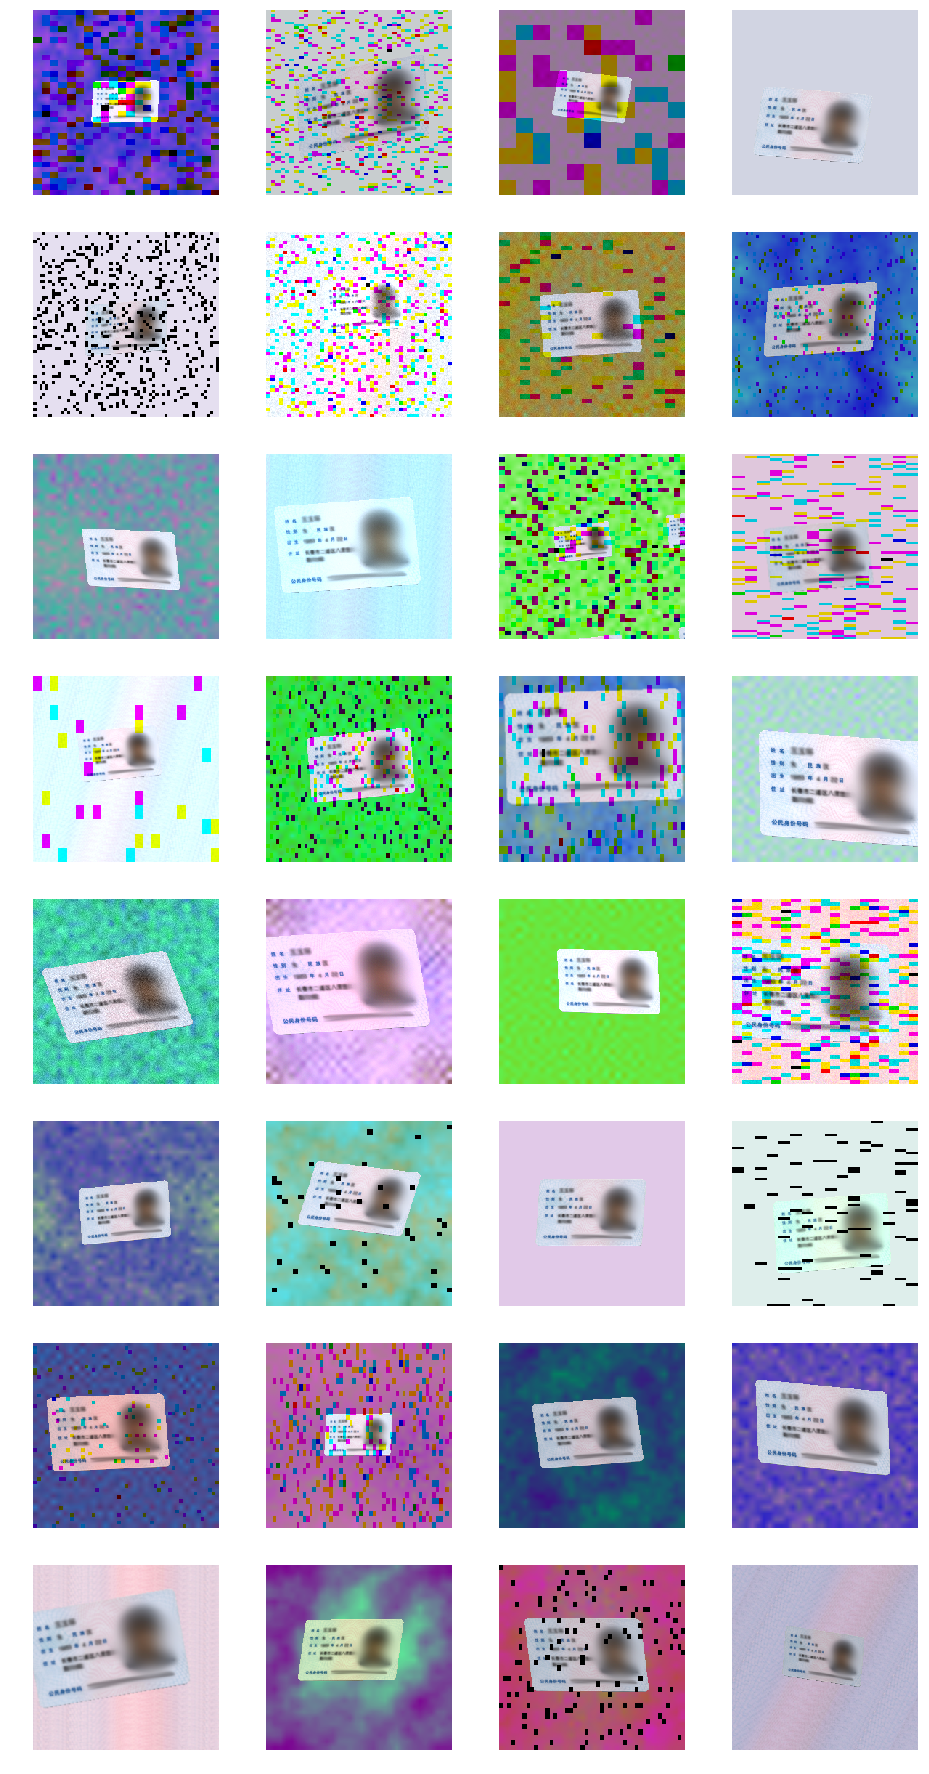

In [11]:
rows = 8
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(4*cols,4*rows))
for i in range(rows):
    for j in range(cols):
        axes[i, j].set_axis_off()
        axes[i, j].imshow(train_x[i * cols + j]);

In [ ]:
# acc = []
# val_acc = []
# for _ in range (50):
#     history = model.fit(train_x, train_y,
#                         batch_size=32,
#                         epochs=1,
#                         verbose=1,
#                         validation_split=0.1
#                        )    
#     acc_ = history.history['my_iou_metric'][0]
#     val_acc_ = history.history['val_my_iou_metric'][0]
#     acc.append(acc_)
#     val_acc.append(val_acc_)
#     if acc_ > 0.99:
#         break

In [ ]:
# df = pd.DataFrame({'x': list(range(len(acc))), 'y': acc})
# sns.lmplot(x="x", y="y", data=df, order=2);

In [ ]:
# df = pd.DataFrame({'x': list(range(len(val_acc))), 'y': val_acc})
# sns.lmplot(x="x", y="y", data=df, order=2);